In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

from plotting_spectra import *

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
# Here the lightcurves are loaded
lightcurves_alercextns = pd.read_pickle('./data/lightcurves/lcs_transients_20240517.pkl')
lightcurves_alercextns

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf
0,ZTF19abgpgyp,1515523874715015006,681120247.0,59269.523877,2,20.385720,0.211641
1,ZTF19abgpgyp,1499511354715015014,NaN,59253.511354,2,20.678400,0.258971
2,ZTF19abgpgyp,1502430264715015014,NaN,59256.430266,2,20.652500,0.269586
3,ZTF19abgpgyp,1510536184715015009,NaN,59264.536181,2,20.663600,0.299923
4,ZTF18abjswhy,1515520891415015005,685120214.0,59269.520891,2,16.079460,0.030863
...,...,...,...,...,...,...,...
4546324,ZTF19ablwbut,1508538592115015009,NaN,59262.538599,1,17.079200,0.062217
4546325,ZTF19ablwbut,1511512652115015011,NaN,59265.512651,1,17.125100,0.057529
4546326,ZTF19ablwbut,1513537042115015020,NaN,59267.537049,1,17.073800,0.073881
4546327,ZTF19ablwbut,1515495032115015010,NaN,59269.495035,1,17.232900,0.056399


In [3]:
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv')
spectra_metadata.head()

/tmp/ipykernel_16721/350166623.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv')


,Obj. ID,IAU name,Internal name/s,Obj. RA,Obj. DEC,Obj. Type,Redshift,Spec. ID,Obs-date,JD,...,Grating,Blaze,Lambda-min,Lambda-max,Del-Lambda,Contrib,Publish,Remarks,Created by,Creation date
0,5875,SN 1999Z,NaN,155.65513,27.3555,SN IIn,0.051,17656,1999-02-09 00:00:00.00,2451218.5,...,NaN,NaN,3720.0,7540.5,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
1,5875,SN 1999Z,NaN,155.65513,27.3555,SN IIn,0.051,17657,1999-02-10 00:00:00.00,2451219.5,...,NaN,NaN,3720.0,7540.5,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
2,5875,SN 1999Z,NaN,155.65513,27.3555,SN IIn,0.051,17658,1999-02-13 00:00:00.00,2451222.5,...,NaN,NaN,3720.0,7540.5,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
3,5875,SN 1999Z,NaN,155.65513,27.3555,SN IIn,0.051,17659,1999-02-23 00:00:00.00,2451232.5,...,NaN,NaN,3720.0,7540.5,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53
4,5875,SN 1999Z,NaN,155.65513,27.3555,SN IIn,0.051,17660,1999-04-10 00:00:00.00,2451278.5,...,NaN,NaN,3720.0,7540.5,1.499411,NaN,NaN,Data was ingested from the &lt;a href=&#039;ht...,Migration From WISeREP1.0,2013-07-08 09:12:53


In [4]:
rare_supernova = spectra_metadata[spectra_metadata['IAU name'] == 'SN 2022qzr']
rare_supernova['Lambda-min']

5259    3700.0
5260     330.0
5261    3300.0
Name: Lambda-min, dtype: float64

In [5]:
rare_supernova['Spec. units']

5259    erg cm(-2) sec(-1) Ang(-1)
5260    erg cm(-2) sec(-1) Ang(-1)
5261    erg cm(-2) sec(-1) Ang(-1)
Name: Spec. units, dtype: object

In [6]:
spectra_data = pd.read_pickle('spectra_ALeRCE20240704_x_wisrep_20240622.pkl')
spectra_data

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,NaN,SN2022pru,Lick-3m_KAST,59788.215972,3206.34,10915.01,1838,3504.527001,10393.131809,"[2.2633771763432984, 2.7388705744561315, 2.365...","[0.21898910712578754, 0.1979063641775711, 0.18..."
1,NaN,SN2022ytx,LT_SPRAT,59886.979942,3206.34,10915.01,1838,4047.600000,7994.400000,"[-1.149378218494491, -0.4815124591937457, 0.58...","[0.02170248062794458, 0.36034818699792165, 0.2..."
2,NaN,SN2022ytx,LT_SPRAT,59907.898866,3206.34,10915.01,1838,4066.000000,7994.400000,"[0.5816700646397295, 0.42704860952865736, 0.28...","[0.2633190522450036, 0.12698204152460923, 0.16..."
3,NaN,SNLS-07D3do,Gemini-N_GMOS,54200.000000,3206.34,10915.01,1838,5104.440000,9352.610000,"[1.3701777199999997e-18, 5.391721933333332e-19...","[1.5368479599410815e-18, 1.394673534721022e-18..."
4,NaN,SNLS-07D3do,Gemini-N_GMOS,54200.000000,3206.34,10915.01,1838,5048.346943,9355.344674,"[1.4337395000000001e-18, 6.124360000000001e-19...","[1.797687567656606e-18, 1.8212694935234954e-18..."
...,...,...,...,...,...,...,...,...,...,...,...
25948,ZTF21aanvncv,SN2021efd,NOT_ALFOSC,59277.154005,3206.34,10915.01,1838,3399.900000,9675.765091,"[1.380389e-16, -2.7406190000000003e-17, 7.2966...","[9.342260744967236e-17, 8.189705456575588e-17,..."
25949,ZTF20aauoipy,SN2020etk,LT_SPRAT,58970.392257,3206.34,10915.01,1838,4020.000000,7994.400000,"[1.36587, 1.90187, 1.33649, 1.34496, 1.45294, ...","[0.44910237291240807, 0.34667301062037215, 0.2..."
25950,ZTF20abkwvgc,SN2020oqp,P60_SEDM,59047.214850,3206.34,10915.01,1838,3776.700000,9223.300000,"[2.82e-16, 2.642e-16, 2.681e-16, 2.844e-16, 3....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
25951,NaN,SDSS-SN-082,Sloan_SDSS-Spec,54233.000000,3206.34,10915.01,1838,3822.082000,9189.671900,"[1.1208449500000001e-17, 1.6475109666666668e-1...","[1.1354836383504999e-17, 1.118140824452677e-17..."


In [7]:
lambda_data_max = np.array(spectra_data.lambda_data_max)
lambda_data_max = lambda_data_max[lambda_data_max > 10915.01]

In [51]:
lambda_data_min = np.array(spectra_data.lambda_data_min)

# This mask have the values less than 1000 Angstrom
mask_lambda_min_indx = np.where(lambda_data_min <= 2500)[0]
#print(len(np.where(lambda_data_min >= 10915.01)[0]))
#spectra_data.iloc[mask_lambda_min_indx[1]].lambda_data_min
lambda_data_min.max()

51567.6

In [67]:
# usar el percentil 10 de los minimos
# Usar el percentil 90 de las maximos

spectra_data.lambda_data_min.quantile(0.1)

3302.956540010798

In [11]:
mask = np.ones(len(spectra_data), dtype=bool)
mask[mask_lambda_min_indx] = False
masked_spectra_data = spectra_data.iloc[mask].reset_index(drop=True)
masked_spectra_data = masked_spectra_data[masked_spectra_data.lambda_data_min <= 5000]

In [12]:
from sklearn.preprocessing import StandardScaler

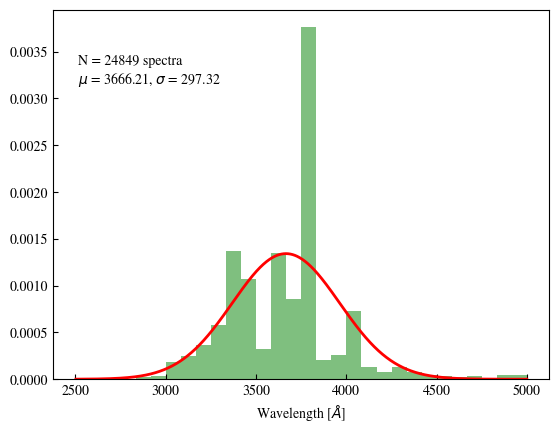

In [13]:
# Calcular los valores de la función gaussiana
x = np.linspace(masked_spectra_data.lambda_data_min.min(), masked_spectra_data.lambda_data_min.max(), 1000)
mu, sigma = masked_spectra_data.lambda_data_min.mean(), masked_spectra_data.lambda_data_min.std()

def gaussian(x, mu, sig):
    return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

# Crear la figura de matplotlib
fig, ax = plt.subplots()

# Graficar el histograma de los datos originales con densidad normalizada
n, bins, patches = ax.hist(masked_spectra_data.lambda_data_min, bins=30, density=True, alpha=0.5, color='g')

# Normalizar el histograma
bin_centers = 0.5 * (bins[1:] + bins[:-1])
scale_factor = np.sum(n * np.diff(bins))
n_normalized = n / scale_factor

# Graficar la curva gaussiana normalizada
ax.plot(x, gaussian(x, mu, sigma) / scale_factor, 'r', linewidth=2)

# Etiquetas y título
#ax.set_ylabel("Densidad Normalizada")
ax.set_xlabel(r"Wavelength [$\AA$]")
#ax.set_title("Histograma y Curva Gaussiana Normalizados")

# Añadir el texto con mu y sigma
ax.text(0.05, 0.8, s='N = %d spectra'%(len(masked_spectra_data.lambda_data_min)) \
        +'\n'+r'$\mu$ = %.2f, $\sigma$ = %.2f' %(mu, sigma), transform=ax.transAxes)

# Mostrar la gráfica
plt.show()

In [153]:
spectra_data_oid_non_nan = spectra_data.dropna()
condition = spectra_data_oid_non_nan.pivot_table(index='oid', aggfunc='size') >= 4
test = spectra_data_oid_non_nan[spectra_data_oid_non_nan.oid.isin(condition[condition].index)]
test[130:140]

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
662,ZTF22aaaepfm,SN2022ji,P200_DBSP,59722.000000,3206.34,10915.01,1838,3200.062019,9999.356858,"[1.9067453302302761, 2.6674102607667236, 0.835...","[2.166299164575969, 2.563458143336989, 2.67871..."
663,ZTF22aaaepfm,SN2022ji,P60_SEDM,59599.537280,3206.34,10915.01,1838,3776.700000,9223.300000,"[2.3761631137602652, 2.727179088328568, 2.7454...","[0.9094613875208506, 0.6693306776058717, 0.825..."
664,ZTF22aaaepfm,SN2022ji,P60_SEDM,59718.266725,3206.34,10915.01,1838,3776.700000,9223.300000,"[2.3761631137602652, 2.727179088328568, 2.7454...","[0.9094613875208506, 0.6693306776058717, 0.825..."
1035,ZTF22aaacvyy,SN2022pr,LT_SPRAT,59639.958333,3206.34,10915.01,1838,4029.200000,7994.400000,"[0.4704636182106742, 1.130324738605469, 0.5257...","[0.22844950036252593, 0.23536664569581447, 0.2..."
1036,ZTF22aaacvyy,SN2022pr,LT_SPRAT,59640.237130,3206.34,10915.01,1838,4020.000000,7994.400000,"[0.7555672865163857, 0.4704636182106742, 1.130...","[0.14041551858303505, 0.22844950036252593, 0.2..."
1037,ZTF22aaacvyy,SN2022pr,Lick-3m_KAST,59788.215972,3206.34,10915.01,1838,3504.527001,10393.131809,"[0.8423122055987905, 1.0365920267751005, 1.346...","[0.4296839443487603, 0.39460225598259147, 0.36..."
1038,ZTF22aaacvyy,SN2022pr,Lick-3m_KAST,59788.222222,3206.34,10915.01,1838,3504.526889,10496.428349,"[0.8423122055987905, 1.0365920267751005, 1.346...","[0.4296839443487603, 0.39460225598259147, 0.36..."
1039,ZTF22aaacvyy,SN2022pr,P60_SEDM,59798.400833,3206.34,10915.01,1838,3776.700000,9223.300000,"[0.667459333009154, 0.6550346708073813, 0.6475...","[0.15490151738695696, 0.12930921200675413, 0.1..."
1040,ZTF22aaacvyy,SN2022pr,UH88_SNIFS,59788.444444,3206.34,10915.01,1838,3402.860000,9078.860000,"[1.213179e-15, 1.133356e-15, 1.18397e-15, 1.21...","[3.7916942119718246e-17, 3.677390167564287e-17..."
1049,ZTF21aaahtln,SN2021gd,ESO-NTT_EFOSC2-NTT,59316.267183,3206.34,10915.01,1838,3650.048340,9245.227457,"[1.05480832e-16, 1.085423635e-16, 9.320210285e...","[3.9546727511497587e-17, 4.135912612957995e-17..."


In [158]:
spectrum = spectra_data[spectra_data.snname == 'SN2021gd']
spectrum

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
1049,ZTF21aaahtln,SN2021gd,ESO-NTT_EFOSC2-NTT,59316.267183,3206.34,10915.01,1838,3650.04834,9245.227457,"[1.05480832e-16, 1.085423635e-16, 9.320210285e...","[3.9546727511497587e-17, 4.135912612957995e-17..."
1050,ZTF21aaahtln,SN2021gd,P60_SEDM,59231.401400,3206.34,10915.01,1838,3776.70000,9223.300000,"[3.6409620225e-16, 4.615042e-16, 5.01596666666...","[1.2071214739422443e-16, 1.3097715175310187e-1..."
1051,ZTF21aaahtln,SN2021gd,P60_SEDM,59292.354051,3206.34,10915.01,1838,3776.70000,9223.300000,"[3.6409620225e-16, 4.615042e-16, 5.01596666666...","[1.2071214739422443e-16, 1.3097715175310187e-1..."
1052,ZTF21aaahtln,SN2021gd,UH88_SNIFS,59293.367245,3206.34,10915.01,1838,3402.86000,9099.860000,"[1.726054e-16, 1.71431e-16, 1.904138e-16, 1.86...","[1.0035616718011578e-17, 1.0350189959934039e-1..."


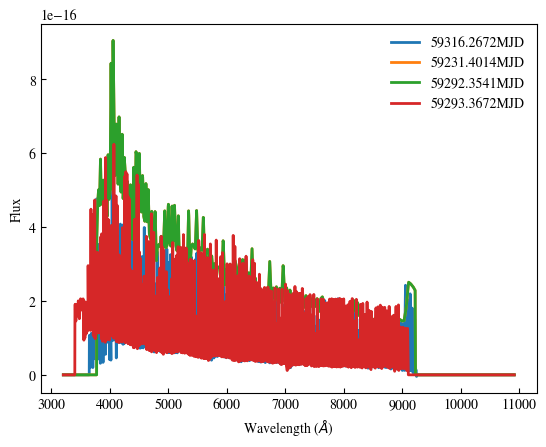

In [159]:
plot_spectra(spectrum, use_lambda_grid=True)

In [160]:
objective_ligtcurve = lightcurves_alercextns[lightcurves_alercextns.oid == spectrum.oid.unique()[0]]
objective_ligtcurve

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf
801329,ZTF21aaahtln,1526278842415015007,712120224.0,59280.278843,2,20.341309,0.186969
801331,ZTF21aaahtln,1514322342415015003,NaN,59268.322349,2,20.076900,0.241257
1453992,ZTF21aaahtln,1465357172415015002,712120224.0,59219.357176,2,18.910633,0.085007
1453993,ZTF21aaahtln,1473447322415015006,NaN,59227.447326,1,18.446000,0.069452
1479586,ZTF21aaahtln,1475426062415015002,712120224.0,59229.426065,2,18.475786,0.077234
1541744,ZTF21aaahtln,1469381092415015004,712120124.0,59223.381100,1,18.514591,0.066307
1590063,ZTF21aaahtln,1463435302415015004,712120124.0,59217.435301,1,18.921488,0.094786
1598451,ZTF21aaahtln,1467405482415015002,NaN,59221.405486,2,18.709300,0.084887
1624705,ZTF21aaahtln,1475445522415015006,NaN,59229.445521,1,18.456300,0.071674
1646699,ZTF21aaahtln,1471447412415015015,NaN,59225.447419,1,18.484400,0.079614


In [119]:
spectrum_test = spectrum.iloc[0]
spectrum_test

oid                                                     ZTF19aadnwbv
snname                                                      SN2019wd
instrument                                        ESO-NTT_EFOSC2-NTT
mjd                                                     58826.280434
lambda_grid_min                                              3206.34
lambda_grid_max                                             10915.01
nlambda_grid                                                    1838
lambda_data_min                                          3642.047852
lambda_data_max                                          9237.227452
flux_lambda        [1.01550995e-15, 8.500509800000001e-16, 8.8599...
e_flux_lambda      [2.0719104242844569e-16, 1.8362907265364682e-1...
Name: 100, dtype: object

In [96]:
wavelength_lsst = {
    'u': [3206.34, 4081.51],
    'g': [3876.02, 5665.33],
    'r': [5377.19, 7055.16],
    'i': [6765.77, 8325.05],
    'z': [8035.39, 9375.47],
    'y': [9089.07, 10915.01],
}

wavelength_ztf ={
    'g' : [3676.00, 5613.82],
    'r' : [5497.60, 7394.40],
    'i' : [6870.97, 8964.61],
}

In [97]:
def obtain_lambda_grid(df:pd.Series) -> list[float]:

    lambda_grid = np.logspace(start=np.log10(df.lambda_grid_min),
                stop=np.log10(df.lambda_grid_max),
                num=df.nlambda_grid)

    return lambda_grid

In [98]:
def interpolate_flux(df:pd.Series) -> list[float]:
    
    lambda_grid = obtain_lambda_grid(df)
    
    flux = np.array(df.flux_lambda)
    lambda_data = np.logspace(start=np.log10(df.lambda_data_min),
                stop=np.log10(df.lambda_data_max),
                num=len(flux))

    f = interpolate.interp1d(lambda_data, flux, fill_value=np.nan, bounds_error=False)
    flux_new = f(lambda_grid)

    return flux_new 


In [99]:
def simpler_intergrate(x:list[float],y:list[float]) -> float:
    
    y = np.nan_to_num(y, nan=0.0)
    
    integral = 0
    
    LSUN = const.L_sun

    for i in range(1,len(x)):
        delta_x = x[i] - x[i-1]
        integral += y[i-1] * delta_x

    return integral

In [166]:
def obtain_luminosity_condition(df:pd.Series, instrument:str):

    lambda_grid = obtain_lambda_grid(df)
    flux = interpolate_flux(df)

    luminosity_list = []

    if instrument == 'ztf':
        bandpasses = ['g','r','i']

        for bandpass in bandpasses:
            condition = np.where((wavelength_ztf[bandpass][0] < lambda_grid) & (wavelength_ztf[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))
            

    elif instrument == 'lsst':
        bandpasses = ['u','g','r','i','z','y']

        for bandpass in bandpasses:
            condition = np.where((wavelength_lsst[bandpass][0] < lambda_grid) & (wavelength_lsst[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))

    else:
        return print('There is not that instrument in list')

Comparar con una curva de ztt. Recordar covertir el flujo to magnitufde

In [167]:
def convert_flux2mag(flux_nu:float, lambda_value: float) -> float:
    # https://en.wikipedia.org/wiki/AB_magnitudes
    mab = -2.5*np.log10(lambda_value**2/ CSPEED * flux_nu) - 48.60
    return mab

/tmp/ipykernel_4739/3956935213.py:3: RuntimeWarning: invalid value encountered in log10
  mab = -2.5*np.log10(flux) - 48.60


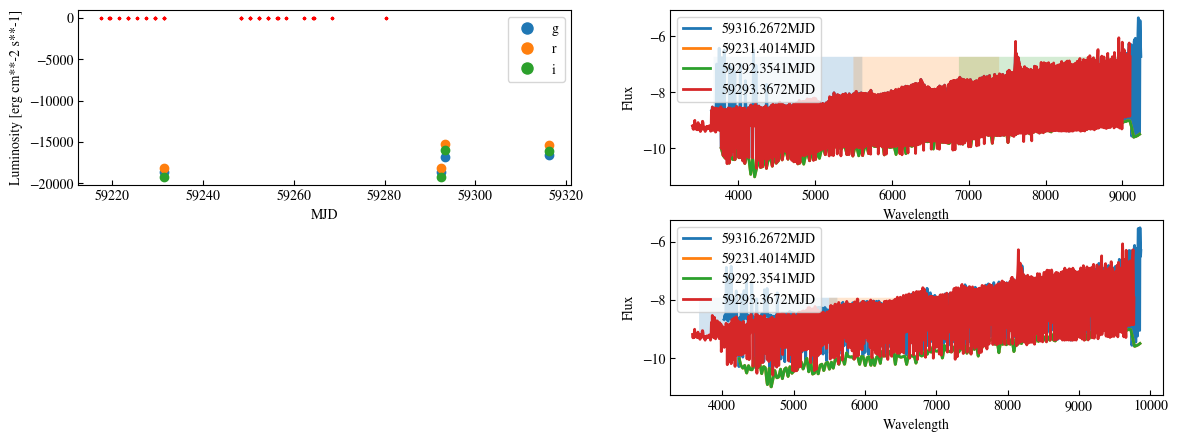

In [170]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(14,5))

instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']


for _, row in spectrum.iterrows():

    # This calculate the x-axis and y-axis of the spectrum
    x_spectrum = np.linspace(row.lambda_data_min,row.lambda_data_max, len(row.flux_lambda))
    y_spectrum = convert_flux2mag(row.flux_lambda)

    x_spectrum_grid = np.linspace(row.lambda_grid_min,row.lambda_grid_max, row.nlambda_grid)
    y_spectrum_grid = convert_flux2mag(interpolate_flux(row))

    for group_name, group in objective_ligtcurve.groupby('fid'):
        ax0.scatter(x=group.mjd, y=group.magpsf, s=2,
                    color='green' if group_name == '1' else 'red')
    # This calculate the luminosity of the spectrum based on
    # the integration of the flux
    luminosity_integrated = obtain_luminosity_condition(df=row, instrument=instrument)
    for bandapass, luminosity in luminosity_integrated.items():
        #ax0.scatter(row.mjd,luminosity)
        if instrument == 'ztf':
            ax0.scatter(row.mjd,luminosity, color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2])
        else: 
            ax0.scatter(row.mjd,luminosity, 
                        color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5])


    ax1.plot(x_spectrum, y_spectrum,label=f'{row.mjd:.4f}MJD')
    ax1.set_ylabel('Flux')
    ax1.set_xlabel('Wavelength')
    #ax1.text(x=max(x_spectrum)-500,
    #                 y=max(y_spectrum*2),
    #                 s=f'{row.mjd:.4f}MJD')
    ax1.legend()

    ax2.set_axis_off()


    ax3.plot(x_spectrum_grid, y_spectrum_grid,label=f'{row.mjd:.4f}MJD')
    ax3.set_ylabel('Flux')
    ax3.set_xlabel('Wavelength')
    ax3.legend()

if instrument == 'ztf':
    wavelengths = wavelength_ztf
else:
    wavelengths = wavelength_lsst

for bandapass in wavelengths.keys():
    ax1.fill_betweenx(y=y_spectrum,x1=wavelengths[bandapass][0],x2=wavelengths[bandapass][1],alpha=0.2)
                      #fc='white',ec='black',alpha=0.2)
    ax3.fill_betweenx(y=y_spectrum_grid,x1=wavelengths[bandapass][0],x2=wavelengths[bandapass][1],alpha=0.2)
                      #fc='white',ec='black',alpha=0.2)
                      
    
        #ax.scatter(row.mjd,luminosity, color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2])
#ax.scatter(row.mjd,luminosity,color = "green" if 'g' in bandapass else "red" if 'r' in bandapass else "blue")    
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=band)
           for band, color in zip(bands, colors)]
ax0.set_ylabel('Luminosity [erg cm**-2 s**-1]')
ax0.set_xlabel('MJD')
ax0.legend(handles=patches)

plt.show()

{'g': 2.4500926084201098e-12, 'r': 1.299461211557886e-12, 'i': 1.0093391725327336e-12}
{'g': 2.3840897225157626e-12, 'r': 1.1408051984538748e-12, 'i': 1.015423357412568e-12}


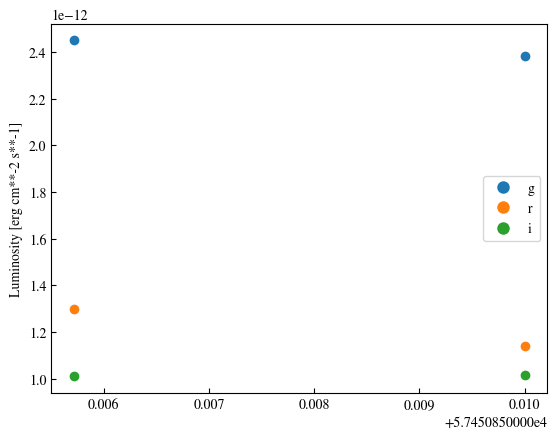

In [ ]:
fig, ax = plt.subplots()
bands = ['g', 'r', 'i']
colors = ['C0', 'C1', 'C2']
for _, row in spectrum.iterrows():
    #print(row)
    luminosity_integrated = obtain_luminosity_condition(df=row, instrument='ztf')
    print(luminosity_integrated)
    for bandapass, luminosity in luminosity_integrated.items():
        ax.scatter(row.mjd,luminosity, color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2])
#ax.scatter(row.mjd,luminosity,color = "green" if 'g' in bandapass else "red" if 'r' in bandapass else "blue")    
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=band)
           for band, color in zip(bands, colors)]
ax.set_ylabel('Luminosity [erg cm**-2 s**-1]')
ax.legend(handles=patches)


In [ ]:
luminosity_g, luminosity_i = [], []

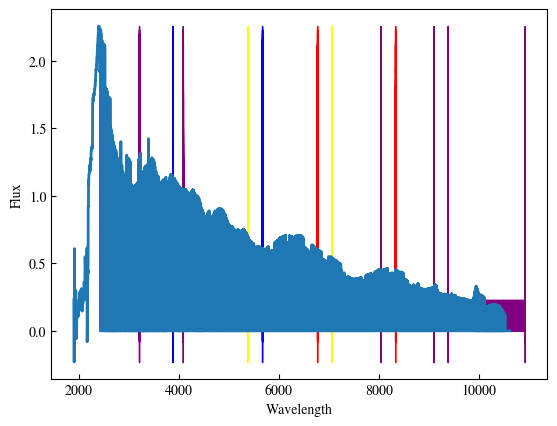

In [39]:
x = np.linspace(spectrum_test.lambda_data_min,spectrum_test.lambda_data_max, len(eval(spectrum_test.flux_lambda)))
y = eval(spectrum_test.flux_lambda)

fig, ax = plt.subplots()
#y = eval(group.flux_lambda)
ax.plot(x, np.array(y))
ax.set_ylabel('Flux')
ax.set_xlabel('Wavelength')
ax.fill_betweenx(y=y,x1=wavelength_lsst['u'][0],x2=wavelength_lsst['u'][1],color='purple')
ax.fill_betweenx(y=y,x1=wavelength_lsst['g'][0],x2=wavelength_lsst['g'][1],color='blue')
ax.fill_betweenx(y=y,x1=wavelength_lsst['r'][0],x2=wavelength_lsst['r'][1],color='yellow')
ax.fill_betweenx(y=y,x1=wavelength_lsst['i'][0],x2=wavelength_lsst['i'][1],color='red')
ax.fill_betweenx(y=y,x1=wavelength_lsst['z'][0],x2=wavelength_lsst['z'][1],color='purple')
ax.fill_betweenx(y=y,x1=wavelength_lsst['y'][0],x2=wavelength_lsst['y'][1],color='purple')

In [40]:
len(y),len(x)


(16117, 16117)

In [41]:
I = integrate.simpson(y[condicion],x[condicion])
I

NameError: name 'integrate' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
for mjd_indt, group in spectrum.groupby('mjd'):
    y = group.flux_lambda.values
    print(y)
    print(len(y))
    print(y.dtype)
    x = np.linspace(group.lambda_data_min.iloc[0],group.lambda_data_max.iloc[0], len(y))
    print(x)
    #y = eval(group.flux_lambda)
    ax.plot(x, np.array(y))
    

Calcualte the magnitud

https://articles.adsabs.harvard.edu/pdf/1996AJ....111.1748F

In [ ]:
integra